In [ ]:
import numpy as np
import random
from sklearn.datasets import load_iris, load_wine
import time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, normalized_mutual_info_score
import matplotlib.pyplot as plt

In [ ]:
def load_dataset(name):
    if name == "wine":
        data = load_wine()
    elif name == "iris":
        data = load_iris()

    return data.data, data.target

def kmeans_plusplus_init(points, k):
    n = len(points)
    centroids = [random.choice(points)]

    for _ in range(1, k):
        distances = np.array([min(np.linalg.norm(p - c) ** 2 for c in centroids) for p in points])
        probabilities = distances / np.sum(distances)
        new_centroid = points[np.random.choice(range(n), p=probabilities)]
        centroids.append(new_centroid)

    return centroids

def k_means_cluster(k, dataset, init_method="random", max_iters=30, tol=1e-6):
    points, labels = load_dataset(dataset)

    if init_method == "random":
        centroids = random.sample(list(points), k)
    elif init_method == "kmeans++":
        centroids = kmeans_plusplus_init(points, k)

    for _ in range(max_iters):
        clusters = [[] for _ in range(k)]
        cluster_assignments = []

        for point in points:
            distances = [np.linalg.norm(point - centroid) for centroid in centroids]
            cluster_index = np.argmin(distances)
            clusters[cluster_index].append(point)
            cluster_assignments.append(cluster_index)
        new_centroids = [np.mean(cluster, axis=0) if cluster else centroids[i] for i, cluster in enumerate(clusters)]
        centroid_shift = np.linalg.norm(np.array(new_centroids) - np.array(centroids))

        if centroid_shift < tol:
            break
        centroids = new_centroids

    return clusters, centroids, labels, np.array(cluster_assignments)

In [ ]:
def elbow(dataset_name, max_k=15):
    X, _ = load_dataset(dataset_name)
    distortions = []

    for k in range(2, max_k + 1):
        _, centroids, _, cluster_assignments = k_means_cluster(k, dataset_name, init_method="random")
        distortion = sum(np.linalg.norm(X[i] - centroids[int(cluster_assignments[i])]) ** 2
                        for i in range(len(X)))
        distortions.append(distortion)
    distortions = np.array(distortions)
    norm_distortions = (distortions - np.min(distortions)) / (np.max(distortions) - np.min(distortions))

    x = np.array(range(2, max_k + 1))
    diffs = np.diff(norm_distortions, 2)
    optimal_k = np.argmax(np.abs(diffs)) + 3

    plt.figure(figsize=(10, 6))
    plt.plot(x, norm_distortions, 'bo-', label='Distortion')
    plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k={optimal_k}')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Normalized Distortion')
    plt.title(f'Elbow Method ({dataset_name} dataset)')
    plt.grid(True)
    plt.legend()
    plt.show()

    return optimal_k, distortions

def silhouette_score(points, cluster_assignments, k):
    n = len(points)
    silhouette_scores = np.zeros(n)

    for i in range(n):
        same_cluster = points[cluster_assignments == cluster_assignments[i]]
        other_clusters = [points[cluster_assignments == j]
                         for j in range(k) if j != cluster_assignments[i]]

        a_i = np.mean([np.linalg.norm(points[i] - p)
                      for p in same_cluster if not np.array_equal(points[i], p)]) \
              if len(same_cluster) > 1 else 0

        b_i = min([np.mean([np.linalg.norm(points[i] - p)
                           for p in cluster])
                  for cluster in other_clusters]) if other_clusters else 0

        silhouette_scores[i] = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) > 0 else 0

    return np.mean(silhouette_scores)

def NMI(true_labels, cluster_labels):
    unique_true = list(set(true_labels))
    unique_cluster = list(set(cluster_labels))
    joint_hist = np.zeros((len(unique_true), len(unique_cluster)))

    for t, c in zip(true_labels, cluster_labels):
        joint_hist[unique_true.index(t)][unique_cluster.index(c)] += 1

    joint_probs = joint_hist / np.sum(joint_hist)
    true_probs = np.sum(joint_probs, axis=1, keepdims=True)
    cluster_probs = np.sum(joint_probs, axis=0, keepdims=True)

    MI = np.nansum(joint_probs * np.log2(joint_probs / (true_probs * cluster_probs)))

    H_true = -np.sum(true_probs * np.log2(true_probs))
    H_cluster = -np.sum(cluster_probs * np.log2(cluster_probs))

    return MI / np.sqrt(H_true * H_cluster) if H_true * H_cluster > 0 else 0

def optimal_k_and_cluster(dataset_name, max_k=15):
    optimal_k, _ = elbow(dataset_name, max_k)
    clusters, centroids, labels, cluster_assignments = k_means_cluster(optimal_k, dataset_name, init_method="random")
    silhouette = silhouette_score(load_dataset(dataset_name)[0], cluster_assignments, optimal_k)
    NMI_score = NMI(labels, cluster_assignments)

    print(f"optimal_k: {optimal_k}")
    print(f"silhouette_score: {silhouette:.4f}")
    print(f"NMI_score: {NMI_score:.4f}")

    return optimal_k, silhouette, NMI_score

In [ ]:
def compare_with_sklearn(dataset_name, k):
    X, y = load_dataset(dataset_name)

    # my
    start = time.time()
    _, my_centroids, _, my_assignments = k_means_cluster(k, dataset_name, init_method="random")
    my_time = time.time() - start

    # sk-learn
    start = time.time()
    kmeans = KMeans(n_clusters=k, init="random", n_init=10, max_iter=30, random_state=42)
    kmeans.fit(X)
    sk_centroids = kmeans.cluster_centers_
    sk_assignments = kmeans.labels_
    sk_time = time.time() - start

    # compare
    my_silhouette = silhouette_score(X, my_assignments, k)
    sk_silhouette = silhouette_score(X, sk_assignments, k)
    my_nmi = normalized_mutual_info_score(y, my_assignments)
    sk_nmi = normalized_mutual_info_score(y, sk_assignments)

    print(f"({dataset_name} Dataset)")
    print(f"My K-means time: {my_time:.4f}sec")
    print(f"SKlearn K-means time: {sk_time:.4f}sec")
    print(f"Silhouette_comparison: My K-means = {my_silhouette:.4f}, Sklearn K-means = {sk_silhouette:.4f}")
    print(f"NMI_comparison: My K-means = {my_nmi:.4f}, Sklearn K-means = {sk_nmi:.4f}")

    return my_centroids, sk_centroids

In [ ]:
def compare_init_methods(dataset_name, k):
    X, y = load_dataset(dataset_name)

    # random
    start = time.time()
    _, rand_centroids, _, rand_assignments = k_means_cluster(k, dataset_name, init_method="random")
    rand_time = time.time() - start
    rand_silhouette = silhouette_score(X, rand_assignments, k)

    # kmeans++
    start = time.time()
    _, plus_centroids, _, plus_assignments = k_means_cluster(k, dataset_name, init_method="kmeans++")
    plus_time = time.time() - start
    plus_silhouette = silhouette_score(X, plus_assignments, k)

    print(f"K = {k} ({dataset_name} dataset)")
    print(f"Random: {rand_time:.4f}sec, Silhouette score: {rand_silhouette:.4f}")
    print(f"K-means++: {plus_time:.4f}sec, Silhouette score: {plus_silhouette:.4f}")

    return rand_centroids, plus_centroids, rand_assignments, plus_assignments

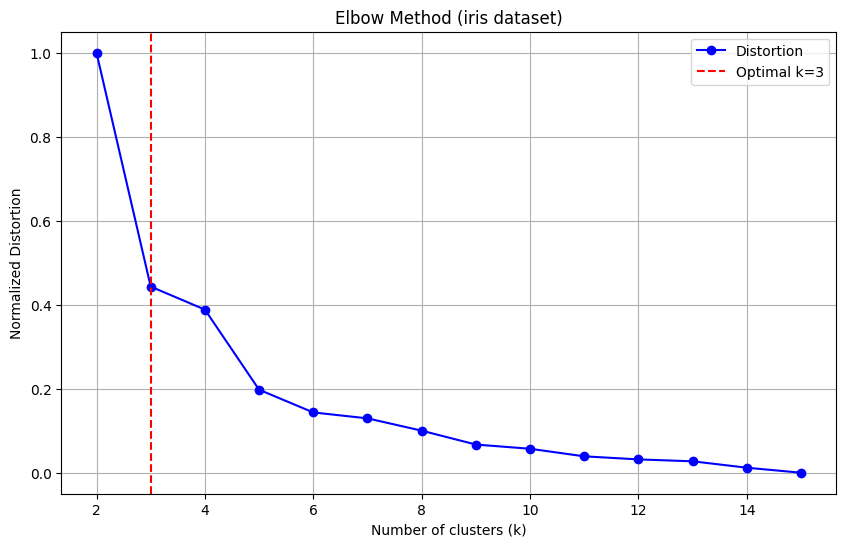

optimal_k: 3
silhouette_score: 0.5510
NMI_score: 0.7419


<ipython-input-100-023594698173>:65: RuntimeWarning: divide by zero encountered in log2
  MI = np.nansum(joint_probs * np.log2(joint_probs / (true_probs * cluster_probs)))
<ipython-input-100-023594698173>:65: RuntimeWarning: invalid value encountered in multiply
  MI = np.nansum(joint_probs * np.log2(joint_probs / (true_probs * cluster_probs)))


(3, 0.5510192720098062, 0.7419322984626251)

In [ ]:
optimal_k_and_cluster("iris")

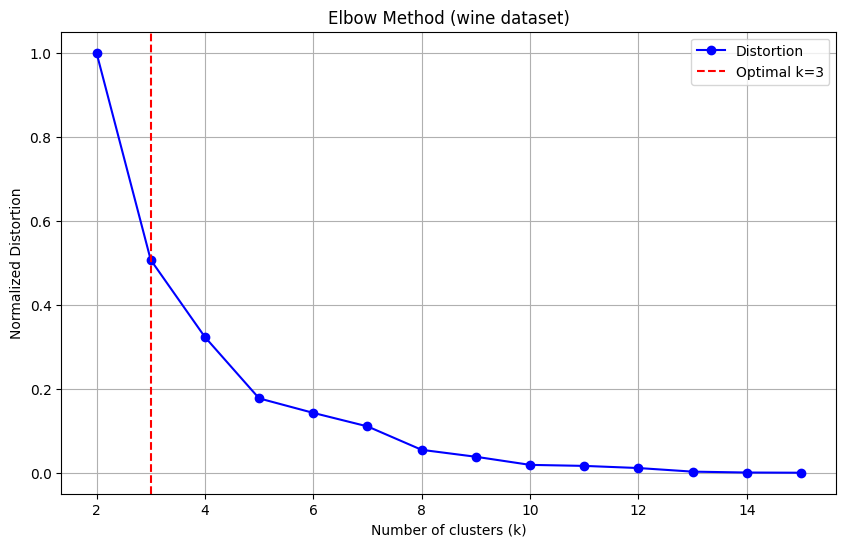

optimal_k: 3
silhouette_score: 0.5711
NMI_score: 0.4288


<ipython-input-100-023594698173>:65: RuntimeWarning: divide by zero encountered in log2
  MI = np.nansum(joint_probs * np.log2(joint_probs / (true_probs * cluster_probs)))
<ipython-input-100-023594698173>:65: RuntimeWarning: invalid value encountered in multiply
  MI = np.nansum(joint_probs * np.log2(joint_probs / (true_probs * cluster_probs)))


(3, 0.5711381937868839, 0.42875686335053037)

In [ ]:
optimal_k_and_cluster("wine")

In [ ]:
compare_init_methods("iris", 3)

K = 3 (iris dataset)
Random: 0.0325sec, Silhouette score: 0.5510
K-means++: 0.0179sec, Silhouette score: 0.5526


([array([5.006, 3.428, 1.462, 0.246]),
  array([5.88360656, 2.74098361, 4.38852459, 1.43442623]),
  array([6.85384615, 3.07692308, 5.71538462, 2.05384615])],
 [array([5.9016129 , 2.7483871 , 4.39354839, 1.43387097]),
  array([5.006, 3.428, 1.462, 0.246]),
  array([6.85      , 3.07368421, 5.74210526, 2.07105263])],
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
        2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2,
        2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0,

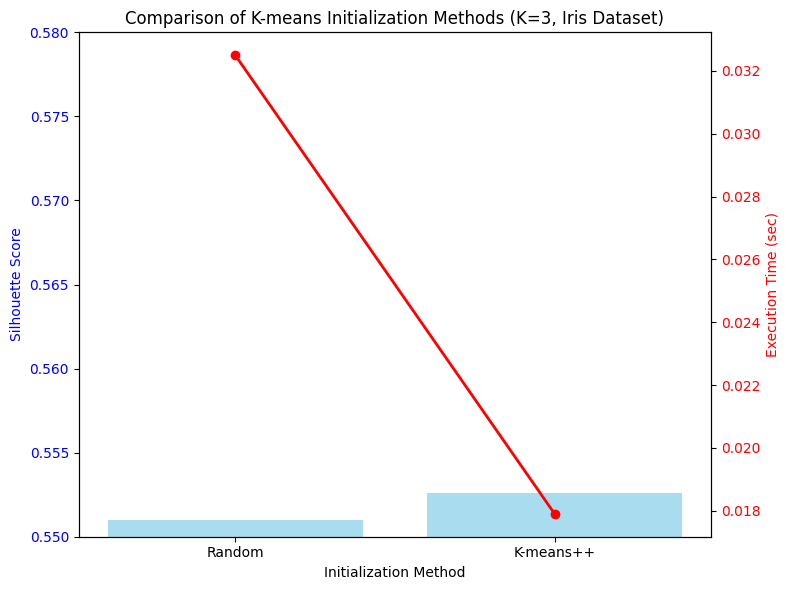

In [ ]:
init_methods = ['Random', 'K-means++']
silhouette_scores = [0.5510, 0.5526]
times = [0.0325, 0.0179]

fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.set_ylim(0.55, 0.58)
ax1.bar(init_methods, silhouette_scores, color='skyblue', alpha=0.7, label='Silhouette Score')
ax1.set_xlabel('Initialization Method')
ax1.set_ylabel('Silhouette Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(init_methods, times, color='red', marker='o', label='Execution Time (sec)', linestyle='-', linewidth=2)
ax2.set_ylabel('Execution Time (sec)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Comparison of K-means Initialization Methods (K=3, Iris Dataset)')
plt.tight_layout()

# 그래프 출력
plt.show()

In [ ]:
compare_init_methods("wine", 3)

K = 3 (wine dataset)
Random: 0.0187sec, Silhouette score: 0.5711
K-means++: 0.0371sec, Silhouette score: 0.5596


([array([1.38044681e+01, 1.88340426e+00, 2.42617021e+00, 1.70234043e+01,
         1.05510638e+02, 2.86723404e+00, 3.01425532e+00, 2.85319149e-01,
         1.91042553e+00, 5.70255319e+00, 1.07829787e+00, 3.11404255e+00,
         1.19514894e+03]),
  array([1.25166667e+01, 2.49420290e+00, 2.28855072e+00, 2.08231884e+01,
         9.23478261e+01, 2.07072464e+00, 1.75840580e+00, 3.90144928e-01,
         1.45188406e+00, 4.08695651e+00, 9.41159420e-01, 2.49072464e+00,
         4.58231884e+02]),
  array([1.29298387e+01, 2.50403226e+00, 2.40806452e+00, 1.98903226e+01,
         1.03596774e+02, 2.11112903e+00, 1.58403226e+00, 3.88387097e-01,
         1.50338710e+00, 5.65032258e+00, 8.83967742e-01, 2.36548387e+00,
         7.28338710e+02])],
 [array([1.25985294e+01, 2.45343137e+00, 2.32186275e+00, 2.06460784e+01,
         9.36960784e+01, 2.05362745e+00, 1.64754902e+00, 3.95980392e-01,
         1.42509804e+00, 4.67333332e+00, 9.17843137e-01, 2.39480392e+00,
         5.21558824e+02]),
  array([1.3850

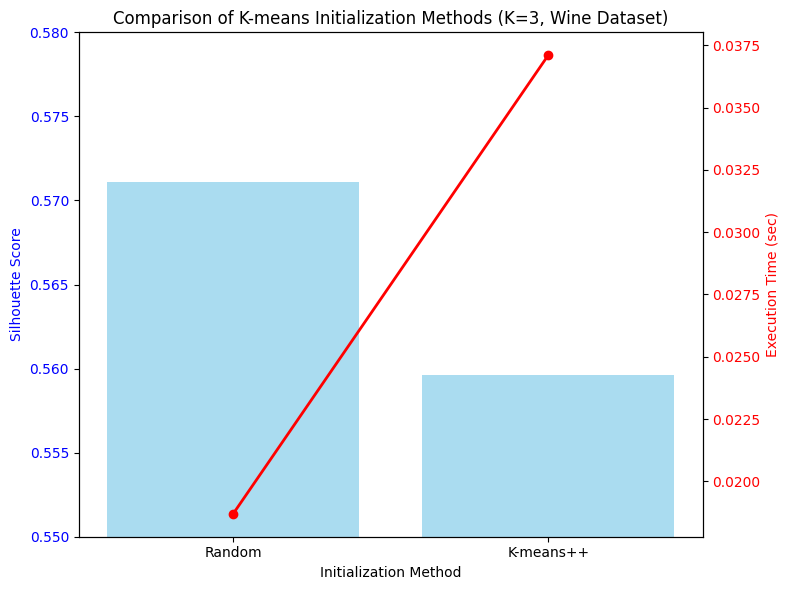

In [ ]:
init_methods = ['Random', 'K-means++']
silhouette_scores = [0.5711, 0.5596]
times = [0.0187, 0.0371]

fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.set_ylim(0.55, 0.58)
ax1.bar(init_methods, silhouette_scores, color='skyblue', alpha=0.7, label='Silhouette Score')
ax1.set_xlabel('Initialization Method')
ax1.set_ylabel('Silhouette Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(init_methods, times, color='red', marker='o', label='Execution Time (sec)', linestyle='-', linewidth=2)
ax2.set_ylabel('Execution Time (sec)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Comparison of K-means Initialization Methods (K=3, Wine Dataset)')
plt.tight_layout()

# 그래프 출력
plt.show()

In [ ]:
compare_with_sklearn("iris", 3)

(iris Dataset)
My K-means time: 0.0111sec
SKlearn K-means time: 0.0141sec
Silhouette_comparison: My K-means = 0.5526, Sklearn K-means = 0.5526
NMI_comparison: My K-means = 0.7582, Sklearn K-means = 0.7582


([array([6.85      , 3.07368421, 5.74210526, 2.07105263]),
  array([5.9016129 , 2.7483871 , 4.39354839, 1.43387097]),
  array([5.006, 3.428, 1.462, 0.246])],
 array([[5.9016129 , 2.7483871 , 4.39354839, 1.43387097],
        [5.006     , 3.428     , 1.462     , 0.246     ],
        [6.85      , 3.07368421, 5.74210526, 2.07105263]]))

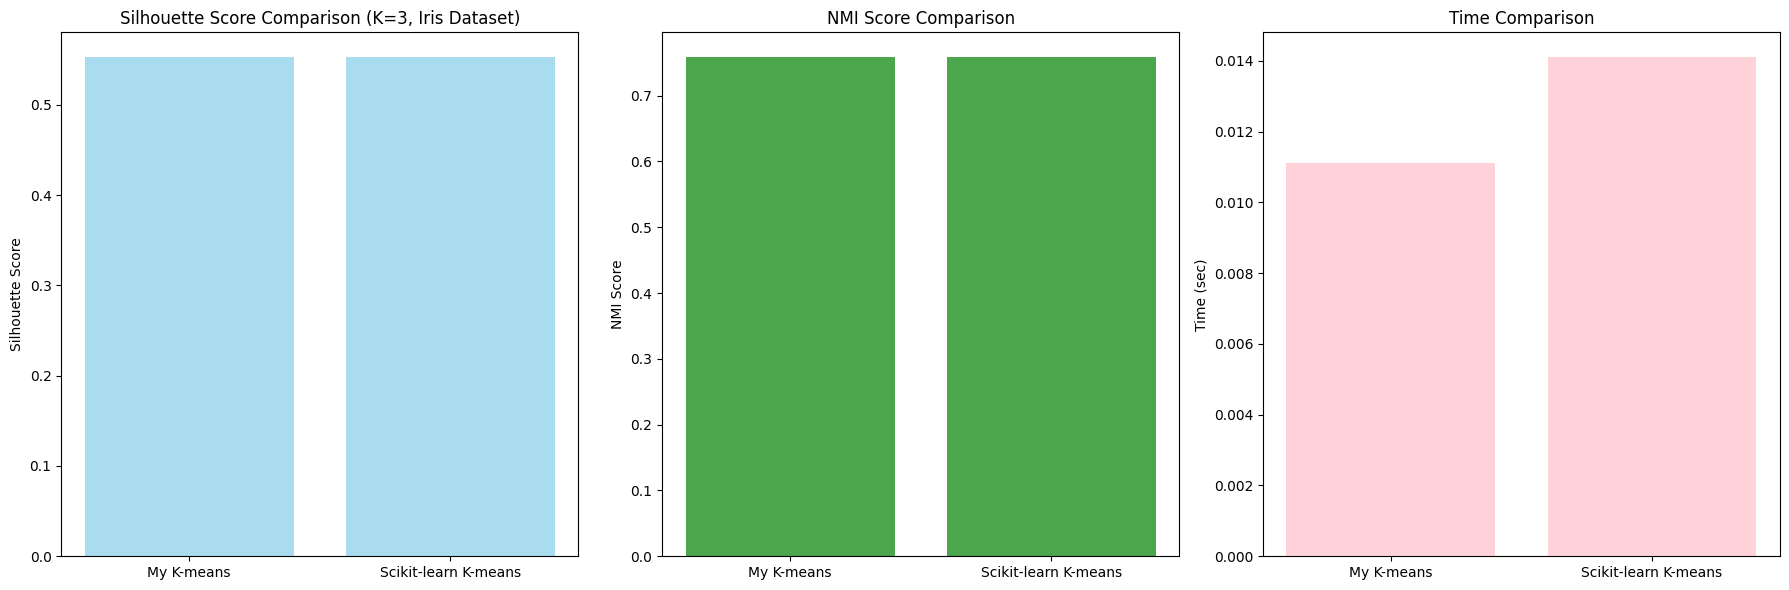

In [ ]:
labels = ['My K-means', 'Scikit-learn K-means']
silhouette_scores = [0.5526, 0.5526]
nmi_scores = [0.7582, 0.7582]
times = [0.0111, 0.0141]

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].bar(labels, silhouette_scores, color='skyblue', alpha=0.7)
ax[0].set_title('Silhouette Score Comparison (K=3, Iris Dataset)')
ax[0].set_ylabel('Silhouette Score')

ax[1].bar(labels, nmi_scores, color='green', alpha=0.7)
ax[1].set_title('NMI Score Comparison')
ax[1].set_ylabel('NMI Score')

ax[2].bar(labels, times, color='pink', alpha=0.7)
ax[2].set_title('Time Comparison')
ax[2].set_ylabel('Time (sec)')

plt.tight_layout()
plt.show()

In [ ]:
compare_with_sklearn("wine", 3)

(wine Dataset)
My K-means time: 0.0141sec
SKlearn K-means time: 0.0157sec
Silhouette_comparison: My K-means = 0.5711, Sklearn K-means = 0.5711
NMI_comparison: My K-means = 0.4288, Sklearn K-means = 0.4288


([array([1.29298387e+01, 2.50403226e+00, 2.40806452e+00, 1.98903226e+01,
         1.03596774e+02, 2.11112903e+00, 1.58403226e+00, 3.88387097e-01,
         1.50338710e+00, 5.65032258e+00, 8.83967742e-01, 2.36548387e+00,
         7.28338710e+02]),
  array([1.25166667e+01, 2.49420290e+00, 2.28855072e+00, 2.08231884e+01,
         9.23478261e+01, 2.07072464e+00, 1.75840580e+00, 3.90144928e-01,
         1.45188406e+00, 4.08695651e+00, 9.41159420e-01, 2.49072464e+00,
         4.58231884e+02]),
  array([1.38044681e+01, 1.88340426e+00, 2.42617021e+00, 1.70234043e+01,
         1.05510638e+02, 2.86723404e+00, 3.01425532e+00, 2.85319149e-01,
         1.91042553e+00, 5.70255319e+00, 1.07829787e+00, 3.11404255e+00,
         1.19514894e+03])],
 array([[1.29298387e+01, 2.50403226e+00, 2.40806452e+00, 1.98903226e+01,
         1.03596774e+02, 2.11112903e+00, 1.58403226e+00, 3.88387097e-01,
         1.50338710e+00, 5.65032258e+00, 8.83967742e-01, 2.36548387e+00,
         7.28338710e+02],
        [1.38044

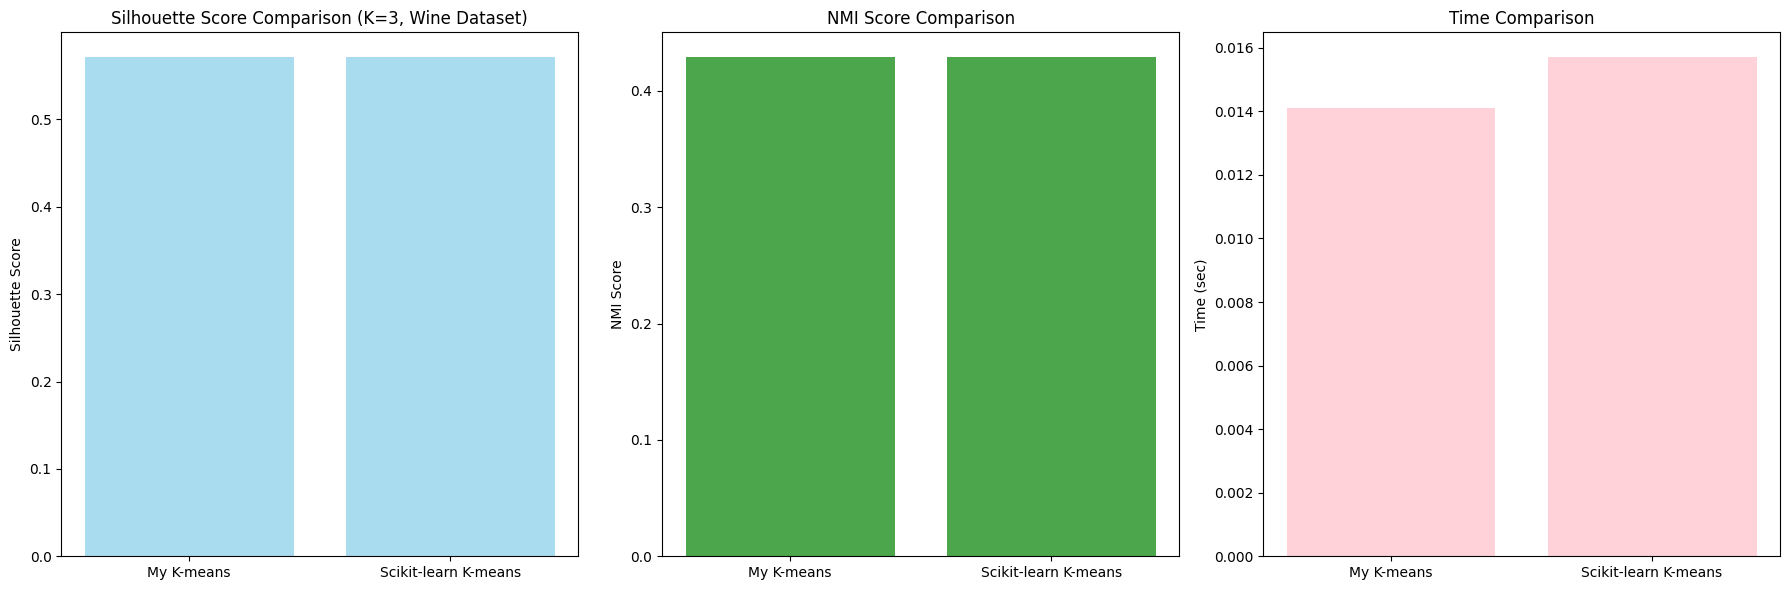

In [ ]:
labels = ['My K-means', 'Scikit-learn K-means']
silhouette_scores = [0.5711, 0.5711]
nmi_scores = [0.4288, 0.4288]
times = [0.0141, 0.0157]

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].bar(labels, silhouette_scores, color='skyblue', alpha=0.7)
ax[0].set_title('Silhouette Score Comparison (K=3, Wine Dataset)')
ax[0].set_ylabel('Silhouette Score')

ax[1].bar(labels, nmi_scores, color='green', alpha=0.7)
ax[1].set_title('NMI Score Comparison')
ax[1].set_ylabel('NMI Score')

ax[2].bar(labels, times, color='pink', alpha=0.7)
ax[2].set_title('Time Comparison')
ax[2].set_ylabel('Time (sec)')

plt.tight_layout()
plt.show()